# Overview
In this notebook we will examine called strike zones and the various factors that influence it. We will use a model based approach that looks for general patterns accross all umpires and games. Some factors we will examine include:
- the handedness of the batter
- the count in the at-bat
- calls on previous pitches
- locations of previous pitches



# Imports

In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt # , seaborn as sns
from base_models import ProbStrike, ModelFitting, Visualization as vis
from mlb_models.download_data import DataLoader
from utils import *
V = vis

diameter_baseball = 2.9/12 # in feet
width_home_plate = 17/12

rule_book_wall = [-0.83, 0.83, 1.53, 3.37] # stable approximation

this_xw = (width_home_plate+diameter_baseball)/2
# avg_sz_bot, avg_sz_top = (1.5735705971433454, 3.353895858746178) #count_box.loc[:, ['R_Top Wall', 'R_Bottom Wall']].median()
# rule_book_walls = [-this_xw,this_xw,avg_sz_bot,avg_sz_top]#+diameter_baseball/2]

# Download Data
For the purposes of this demo we will just examine the 2017 season, this is the only data made available on the git repo. The same patterns hold for different subsets of data but this dataset is more than sufficient to visualize robust patterns while allowing models to converge rapidly. This function loads and merges data from the `/data` folder. The argument `reshrink=True` ensures the variables that can be remain as `categorical` types, greatly reducing memory load.

In [3]:
dl = DataLoader()
season = '2017' # 2017
data = dl.import_data(season=season,add_history=True,reshrink=True)
print(f'This dataset contains {len(data)} pitches')

This dataset contains 738972 pitches


# Strike Zone Model | left vs right batters
## Model
The proabability of being called a strike is the product of the probability of the pitch being inside each of four imaginary walls (eg. not too high, not too low, not too far inside, and not too far outside).

$$P(strike=1) = \prod_{w=1}^{4} F_w(x,z)$$
for the 4 walls {Left, Right, Top Bottom} of the strike zone. The equations for four walls are as follows:
$$ F_1(x|\mu_1,\sigma_x) = \int_{-\inf}^{x} \mathcal{N}(\mu_1,\sigma_x) ~~~~~~~~~~~ F_2(x|\mu_2,\sigma_x) = \int_{-\inf}^{x} 1-\mathcal{N}(\mu_2,\sigma_x) $$

$$ F_3(z|\mu_3,\sigma_z) = \int_{-\inf}^{z} \mathcal{N}(\mu_3,\sigma_z) ~~~~~~~~~~~ F_4(z|\mu_4,\sigma_z) = \int_{-\inf}^{z} 1-\mathcal{N}(\mu_4,\sigma_z).$$

We can estimate the 6 free parameters {$\mu_{1,2,3,4},\sigma_{x,z}$} using Maximum Likelihood Estimation (MLE). While other or more complex representations of the strike zone including arbitrary polynomials are possible, we find this formulation is quite accurate while remaining parsimonious. 

## Implementation
This is accomplished in several steps. This model will be expanded in complexity but for now we ignore other features and use 2-free parameters 
1. Generate a subset of pitches using `dl.get_pitch_use`  including only *called* pitches (eg. the batter didn't swing) and those without errors in pitch registration. Here we additionally use this to subset to only Left or Right handed batters.
1. Extract the features of interest from the dataset using `dl.get_pitch_data`. Here the **x** variable is the (x,y) coordinates of the pitch and the **y** variable is the call (ball or strike). This function also returns *p0* which is the initial values for the coefficients we will estimate and *var_names_full* which are the names of our **x** variables.
1. Define the model to be fit. The model is defined by `ProbeStrike` which when initialized with coefficients returns *p_strike* given inputs **x**. `ModelFitting` is a wrapper function that handles loss minimization.
1. Fit the model coefficients with the `fit_grad` method using gradient descent.

For performance, `ModelFitting` prints *bits gained* relative to a null model (fixed probabilty of called strike) and the *F1-score* of the model predictions overall. 

In [4]:
n_sd = 2
fit_models = []
for batter in ['L','R',None]:
    print(batter)
    pitch_use = dl.get_pitch_use(data,batter=batter)
    xy_full,strikes, var_names_full,p0,_ = dl.get_pitch_data(data, pitch_use=pitch_use,n_sd=n_sd)
    MF_sz = ModelFitting(ProbStrike,data=(xy_full,strikes),model_type='strike_zone',n_sd=n_sd)
    out  = MF_sz.fit_grad(p0)
    fit_models.append(MF_sz.fit_model)

L
Bits gained: 0.618. F1-score: 0.864
R
Bits gained: 0.636. F1-score: 0.872
None
Bits gained: 0.622. F1-score: 0.866


# Strike Zone Visualization
Strike zone for left and right handed batters visualized overlayed above home plate with "rule book" strike-zone shown in black. It is clear that the *called* strike zone shifts dramatically based on the handedness of the batter.

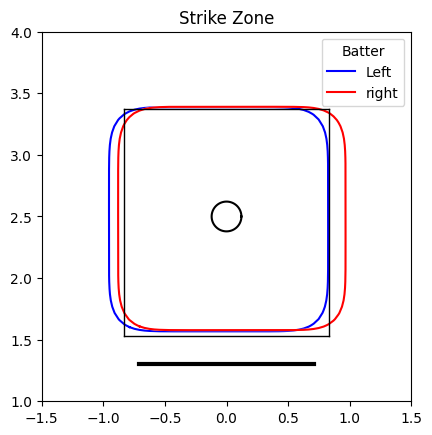

In [5]:
V.vis_prob_box(fit_models[0],color='b',label='Left')
V.vis_prob_box(fit_models[1],color='r',label='right')
V.draw_box(rule_book_wall,lw=1)
V.draw_home_plate(y_loc=1.3)
V.draw_circle(diameter_baseball,loc=(0,2.5))
plt.legend(title='Batter')
plt.xlim([-1.5,1.5])
plt.title('Strike Zone')
plt.gca().set_aspect('equal')
plt.show()

# Logistic Model | history and context
## Model
Here we attempt to predict the probability of a pitch being called a strike based solely on the context in which it is thrown. Namely the count in the current at-bat and the history of recent pitch calls. Note that unlike the **strike zone** model, this approach ignores the actual location of the pitch and thus is largely determined by pitch selection rather than umpire behavior. We achieve this using a logistic model with cofficients for each of 12 possible counts as well as for 2 possible outcomes on each of the 6 previous pitches (called_strike, ball). Including the intercept, this results in a total of 12 + 6*2 + 1 = 25 coefficients to be estimated.



$$ z = \beta_0 + \sum_{n=0}^{n-back}{\beta_{strike}^{n} X_{strike}^n} + \sum_{n=0}^{n-back}{\beta_{ball}^{n} X_{ball}^n} + \sum_{c=0}^{12}{\beta_{count}^{c} X_{count}^c} $$

$$P(strike=1) = \frac{1}{1+e^{-z}} $$

## Implementation

We use a helper function to generate the one-hot encoding of all of the variables we just mentioned. This function also has the ability to encode the number of balls/strikes as an integer. Reducing 12 parameters to 2 while enforcing an assumption of linearity. Once the model input matricies are designed, they are fit in the same manner using gradient descent.


In [6]:
nb_get = 6

x_logistic,strikes, var_names_full, p0 = dl.generate_logistic_data(data,training_want='stack',add_plus_1=False,nb_get=nb_get,
                                                   count_numerical=False, outcomes=('ball', 'called_strike'))
MF_log = ModelFitting(ProbStrike,data=(x_logistic,strikes),model_type='logistic',param_names = var_names_full)
out_log = MF_log.fit_grad(p0)


Bits gained: 0.082. F1-score: 0.406


# Visualizing Logistic Model
Note a strike throw is more likely following a ball or when the count favors the batter. Interestingly, the relationship between P(Strike) and the # of balls when no strikes have been thrown yet (red line, right) is non-monotonic.

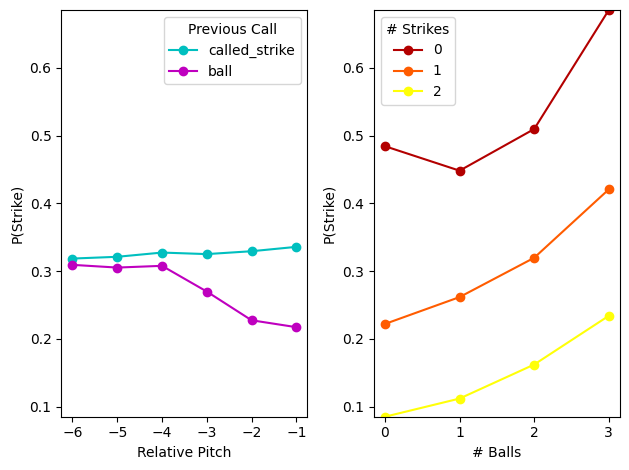

In [7]:
V.vis_logistic_from_model(MF_log.fit_model)
plt.show()

# Joint Model 
## Model
The previous approach was limited in that it did not account for pitch location. Here we concatenate the two model approaches into a single logistic model
$$ z_1 = z_0 + \beta_{strikeZone} logit(p(strike|x,z)) + z_{logistic} $$

$$P(strike=1) = \frac{1}{1+e^{-z_{1}}} $$

Specificially the strike zone paraemeters are used to get an estimate `P(strike|x,z)` which is then logit transformed and added as a data point in out full *joint* model. $z_{logistic}$ refers to the full equation for z described for the logistic model.

## Implementation

The parameters for the strike zone are used to estimate `P(strike|x,z)` which is inserted into dataFrame. This is then input along with the full logistic design matrix and fit using MLE. This is achieved by the argument `add_p_strike`. In addition for this model we opt to reduce the numeber of free-parameters by not using one-hot encoding for the at bat count (argument `count_numerical=True`). We limit the number of model iterations to save time as model performance does not improve meaningfully (at least for demonstration purposes) with more evalutaion steps.

In [8]:
nb_get = 6
data['pStrike'] = np.nan # this is a placeholder -filled in during model fitting with the strike zone model output
n_sd = 2
xy_joint,strikes, var_names_full,p0,_ = dl.get_joint_data(data,batter='R',training_want='stack',add_plus_1=False,nb_get=nb_get,
                                                   count_numerical=True, add_p_strike = True,
                                                   outcomes=('ball', 'called_strike'),n_sd=2)
MF = ModelFitting(ProbStrike,data=(*xy_joint,strikes*1),model_type='joint',param_names = var_names_full,n_sd=n_sd )
MF.get_loss_model(p0) # ensures model will run...

MF.opts = {'maxiter':200} # fit model, save time
out = MF.fit_grad(p0) # challenging optimization

Bits gained: 0.654. F1-score: 0.881


In [9]:
print('Labelled Coeficients: \n', MF.labeled_coef)

Labelled Coeficients: 
 {'Left_Wall': -0.7652471598280909, 'Right_Wall': 0.8501435104363962, 'Bottom_Wall': 1.714605786897153, 'Top_Wall': 3.248333389845701, 'SD X': -1.2836862133607276, 'SD Y': -1.14968883747617, '1': 1.7653648879814474, 'B1-ball': 0.199780841083751, 'B1-called_strike': -0.37142164736296507, 'B2-ball': 0.14093447182118116, 'B2-called_strike': -0.37268678132597816, 'B3-ball': 0.06784586162638141, 'B3-called_strike': -0.20431619808442136, 'B4-ball': 0.08483681961949333, 'B4-called_strike': -0.019836605127436277, 'B5-ball': 0.033011652077813466, 'B5-called_strike': -0.047266890350980285, 'B6-ball': 0.02147399661184627, 'B6-called_strike': -0.023619160908132125, 'balls': 0.2421120097404575, 'strikes': -0.4990565342682254, 'strike_zone': 1.5903205614280946}


# Visualize Joint Model
Unlike the logistic model, this approach focuses on umpire specific biases. By including a strike zone in our model, any shift in expected pitch location should be accounted for by the strike zone, and any lingering bias due to the count or past calls should be related to umpire behavior. Critically, we continue to observe strong biases such as a tendency to switch calls (eg. more likely to call a strike if the previous pitch was called a ball). This suggests that umpires are susceptible to many of the same biases found in studies of typical human observers.

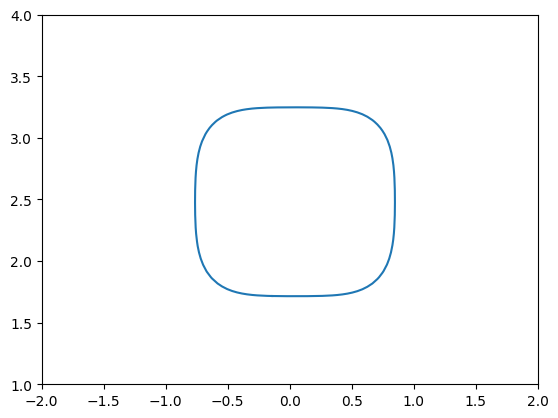

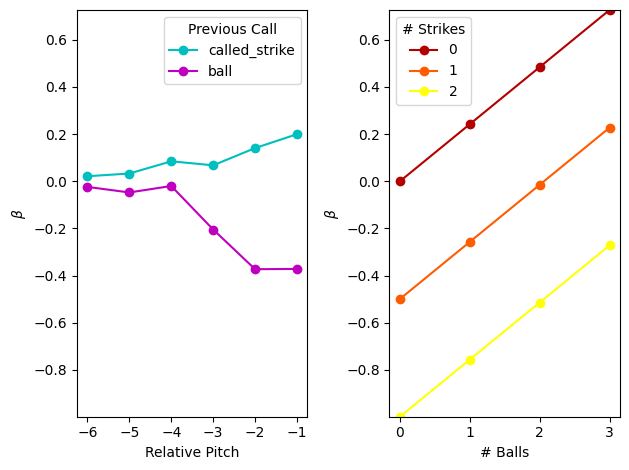

In [10]:
V.vis_prob_box(MF.fit_model)
plt.show()

V.vis_logistic_from_model(MF.fit_model,want_coef=True)
plt.show()

# Show Perceptual bias -- model free and model based
The bias we showed previously was a cognitive one - eg. related to decision making. We are also interested in perceptual biases, eg. how the umpires might percieve things differently based on context. For instance the cognitive bias shown above suggests an umpire is more likely to call any close pitch a strike on a `3-0` count. In contrast a perceptual bias may shape how they see pitches and may instead result in the strike zone itself shifting. We can test for this by seeing (in a model free way) how the probability of a pitch being called a strike changes as a function of the previous pitch location.

/var/folders/kg/xvv37n7x18920y0hk8_ptv880000gn/T/ipykernel_40501/3095138758.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  this_agg_sub = this_data.groupby(['x_bin','stand','x_bin_prev']).strike.mean().reset_index()


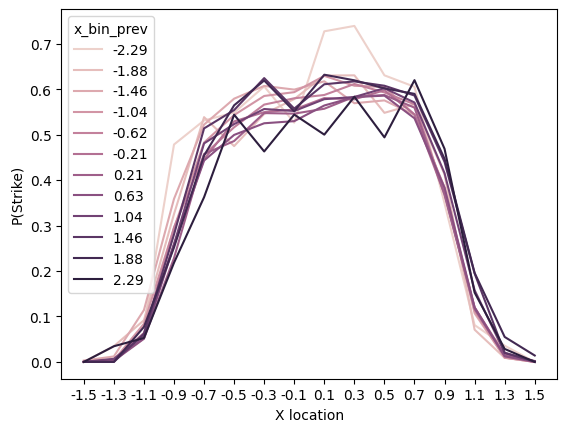

In [11]:
import seaborn as sns
z_min,z_max = 1.8, 3.1
n_bin_cur = 16
bns = np.linspace(-1.6,1.6,n_bin_cur+1)
bn_labs = np.round((bns[:-1] + (bns[1]-bns[0])/2),2).astype(str)

n_bin_prev = 12
bns_prev = np.linspace(-2.5,2.5,n_bin_prev+1)
bn_labs_prev = np.round((bns_prev[:-1] + (bns_prev[1]-bns_prev[0])/2),2).astype(str)

data['x_bin'] = pd.cut(data.plate_x.astype(float),bns,labels=bn_labs)
data['x_bin_prev'] = pd.cut(data.prev_plate_x.astype(float), bns_prev, labels=bn_labs_prev)
query0 = ('called_pitch and ~x_bin.isnull() and ~x_bin_prev.isnull() and ~plate_x.isnull()')

this_data = data.query(query0).copy()
this_data['x_bin'] = this_data['x_bin']
this_data['x_bin_prev'] = this_data['x_bin_prev'].astype(float)
this_agg_sub = this_data.groupby(['x_bin','stand','x_bin_prev']).strike.mean().reset_index()

sns.set_palette('RdBu')
sns.lineplot(data=this_agg_sub[this_agg_sub.stand=='R'],x='x_bin',y='strike',hue='x_bin_prev',legend='full')
plt.ylabel('P(Strike)')
plt.xlabel('X location')
plt.show()



In [12]:
_, coef_original,labeled_coefficients, did_pass, var0 = get_p_strike(this_data,iterate_over='x_bin_prev',want_p_strike=False,n_sd=4,)

Bits gained: 0.611. F1-score: 0.862
Bits gained: 0.660. F1-score: 0.883
1/12 Bits gained: 0.606. F1-score: 0.858
Bits gained: 0.622. F1-score: 0.869
2/12 Bits gained: 0.643. F1-score: 0.874
Bits gained: 0.635. F1-score: 0.869
3/12 Bits gained: 0.616. F1-score: 0.861
Bits gained: 0.646. F1-score: 0.874
4/12 Bits gained: 0.612. F1-score: 0.860
Bits gained: 0.642. F1-score: 0.877
5/12 Bits gained: 0.626. F1-score: 0.865
Bits gained: 0.648. F1-score: 0.877
6/12 Bits gained: 0.632. F1-score: 0.869
Bits gained: 0.639. F1-score: 0.874
7/12 Bits gained: 0.621. F1-score: 0.864
Bits gained: 0.635. F1-score: 0.872
8/12 Bits gained: 0.625. F1-score: 0.864
Bits gained: 0.632. F1-score: 0.870
9/12 Bits gained: 0.628. F1-score: 0.868
Bits gained: 0.640. F1-score: 0.871
10/12 Bits gained: 0.641. F1-score: 0.868
Bits gained: 0.612. F1-score: 0.863
11/12 Bits gained: 0.703. F1-score: 0.888
Bits gained: 0.588. F1-score: 0.860
12/12 

# Visualization
Fitting a strike zone to distinct subsets of previous pitch locations reveals the Point of Subjective Equality (PSE) aka the strike zone line shifts towards the previous pitch location but only on the closest side.

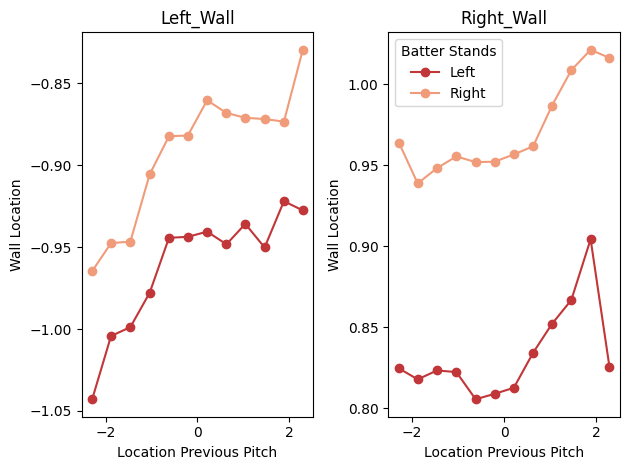

In [13]:
link_sd = ProbStrike().link_sd
def I(x):return x

bn_labs_prev_plot = bn_labs_prev.astype(float)

link_fun = I
plt.figure()
for ind in range(2):
    plt.subplot(1,2,ind+1)
    plt.plot(bn_labs_prev_plot,link_fun(coef_original[:,0,ind]),'o-',label='Left')
    plt.plot(bn_labs_prev_plot,link_fun(coef_original[:,1,ind]),'o-',label='Right')
    plt.title(labeled_coefficients[ind])
    plt.ylabel('Wall Location')
    plt.xlabel('Location Previous Pitch')
plt.legend(title='Batter Stands')
plt.tight_layout()
plt.show()

# Fit with RELU 
- parameterize above bias using a RELU function

In [14]:
# data
n_sd = 2
xy_relu,strikes,var_names,p0,_ =  dl.get_pitch_data(data,get_plate_x_hist=True,n_sd=n_sd)
# p0+=[-.2]
mod_wall_relu = {'params':['relu_amp'], 'relu_pivot':-0.2}
MF_relu = ModelFitting(ProbStrike,data=(xy_relu,strikes),model_type='strike_zone',param_names = var_names,n_sd=n_sd,
                 mod_wall_relu=mod_wall_relu)
MF_relu.opts = {'maxiter': 50}
MF_relu.get_loss_model(p0)

97594.88247320043

In [15]:
out = MF_relu.fit_grad(p0)
print(MF_relu.labeled_coef)

Bits gained: 0.623. F1-score: 0.866
{'Left_Wall': -0.9264388751296752, 'Right_Wall': 0.931321129309376, 'Bottom_Wall': 1.5745538648846973, 'Top_Wall': 3.387988028729391, 'SD X': -1.770301715341283, 'SD Y': -1.6789903603269305, 'relu_amp': 0.029693414742196212}


In [16]:
def logit(p, eps=1e-4):
    if type(p) is np.ndarray:
        p[p < eps] = eps
        p[p > (1 - eps)] = (1 - eps)
    return np.log(p / (1 - p))

def relu(direction, p, xx):
    y = xx.copy()
    amp, offset = p
    closest_ind = np.argmin(np.abs(y-offset))
    if direction > 0:
        y[closest_ind:] -= y[closest_ind]
        y[:closest_ind] = 0
    else:
        y[:closest_ind] -= y[closest_ind]
        y[closest_ind:] = 0
    y *= amp
    return y

def relu_sym(p0, xx,direction = 1):
    p1 = (p0[0], -p0[1])
    y0 = relu(direction, p0, xx)
    y1 = relu(-direction, p1, xx)
    return y0, y1

In [17]:
xx = np.linspace(-3,3)
mod_left, mod_right = relu_sym([MF_relu.labeled_coef['relu_amp'],-.2], xx,-1)
left_wall = mod_left + MF_relu.labeled_coef['Left_Wall']
right_wall = mod_right + MF_relu.labeled_coef['Right_Wall']


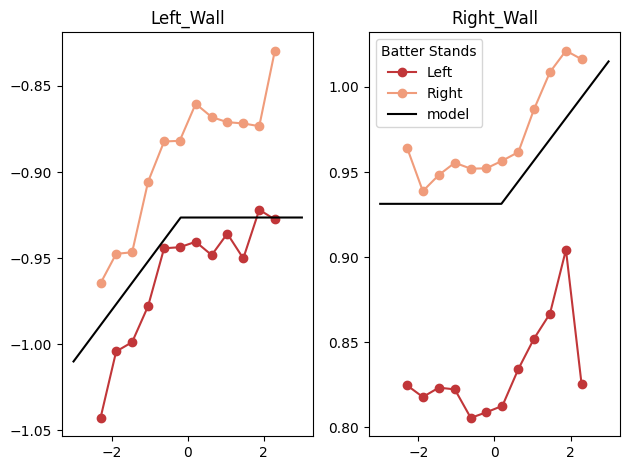

In [18]:
plt.figure()
walls = [left_wall,right_wall]
for ind in range(2):
    plt.subplot(1,2,ind+1)
    plt.plot(bn_labs_prev_plot,link_fun(coef_original[:,0,ind]),'o-',label='Left')
    plt.plot(bn_labs_prev_plot,link_fun(coef_original[:,1,ind]),'o-',label='Right')
    plt.plot(xx,walls[ind],'k',label='model')
    plt.title(labeled_coefficients[ind])
plt.legend(title='Batter Stands')
plt.tight_layout()
plt.show()

# Fit joint model with RELU
## Model
ReLU function parameterizes location of left and right walls.
$$ F_1(x_t, x_{t-1}|\mu_1,\sigma_x, \alpha_{x_{t-1}}) = \int_{-\inf}^{x} \mathcal{N}(\mu_1 + \alpha_{x_{t-1}}ReLU(x_{t-1}),\sigma_x) $$
This allows the walls to shift as a function of pitch history. A seperate parametrization is fit for both left and right walls.

In [19]:
nb_get = 6
data['pStrike'] = np.nan
n_sd = 2
xy_relu_joint,strikes, var_names_full,p0,_ = dl.get_joint_data(data,batter='R',training_want='stack',add_plus_1=False,nb_get=nb_get,
                                                   count_numerical=False, add_p_strike = True,
                                                   outcomes=('ball', 'called_strike'),n_sd=2,get_plate_x_hist=True)
mod_wall_relu = {'params':['relu_amp'], 'relu_pivot':-0.2}


In [20]:
MF_joint_relu = ModelFitting(ProbStrike,data=(*xy_relu_joint,strikes*1),model_type='joint',param_names = var_names_full,n_sd=n_sd,
                            mod_wall_relu=mod_wall_relu)
MF_joint_relu.get_loss_model(p0) # ensures model will run...

MF_joint_relu.opts = {'maxiter':200} # fit model, save time
# MF_joint_relu.minimization_approach = ['Nelder-Mead','BFGS','L-BFGS-B'][0]
out = MF_joint_relu.fit_grad(p0) # challenging optimization
# loss L-BFGS-B = 40075.196
# loss BFGS = 40075.196
# loss Nelder-Mead = 67574.39 (FAIL)

Bits gained: 0.655. F1-score: 0.881


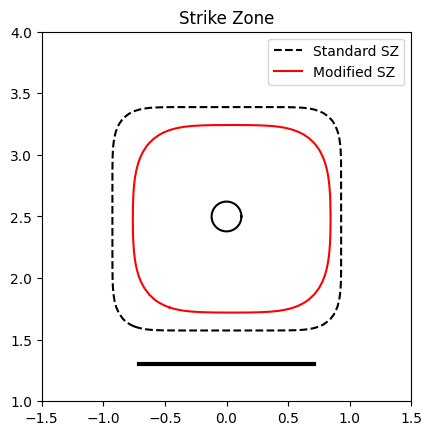

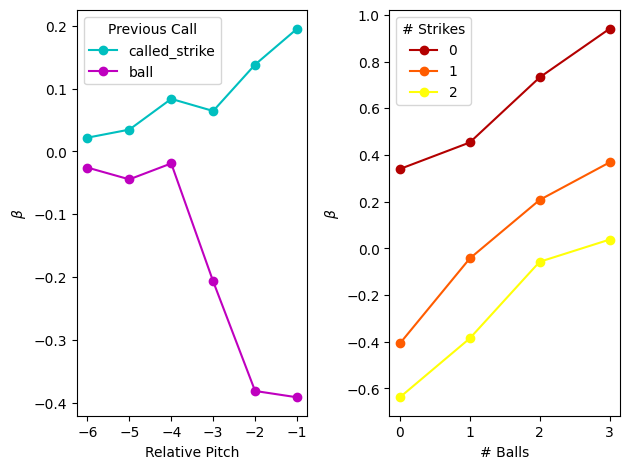

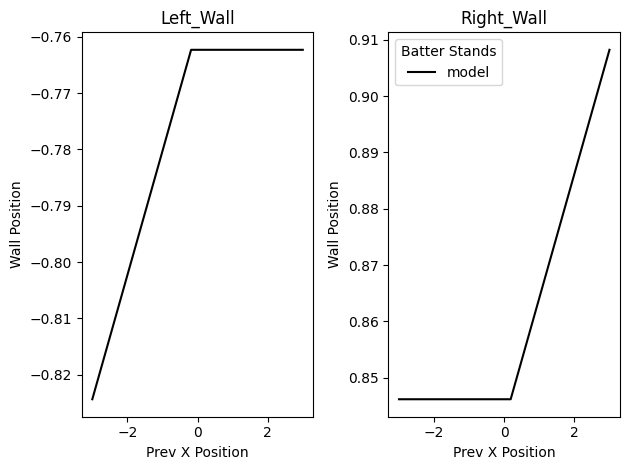

In [21]:
# plt.subplot(1,2,1)

# plt.figure(fi)
V.vis_prob_box(MF_sz.fit_model,color='k',linestyle='--',label='Standard SZ')
V.vis_prob_box(MF_joint_relu.fit_model,color='r',label='Modified SZ')
V.sz_plot(True)
plt.legend()

V.draw_home_plate(y_loc=1.3)
V.draw_circle(diameter_baseball,loc=(0,2.5))
# plt.legend(title='Batter')
plt.xlim([-1.5,1.5])
plt.title('Strike Zone')
plt.gca().set_aspect('equal')
plt.show()

V.vis_logistic_from_model(MF_joint_relu.fit_model,want_coef=True,share_y=False)
plt.show()

xx = np.linspace(-3,3)
mod_left, mod_right = relu_sym([MF_joint_relu.labeled_coef['relu_amp'],-.2], xx,-1)
left_wall = mod_left + MF_joint_relu.labeled_coef['Left_Wall']
right_wall = mod_right + MF_joint_relu.labeled_coef['Right_Wall']

plt.figure()
walls = [left_wall,right_wall]
for ind in range(2):
    plt.subplot(1,2,ind+1)
#     plt.plot(bn_labs_prev_plot,link_fun(coef_original[:,0,ind]),'o-',label='Left')
#     plt.plot(bn_labs_prev_plot,link_fun(coef_original[:,1,ind]),'o-',label='Right')
    plt.plot(xx,walls[ind],'k',label='model')
    plt.title(labeled_coefficients[ind])
    plt.xlabel("Prev X Position")
    plt.ylabel('Wall Position')
plt.legend(title='Batter Stands')
plt.tight_layout()
plt.show()